# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

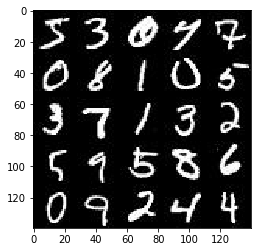

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

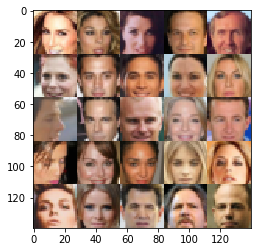

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.6.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_inputs = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name="real_inputs")
    z_input = tf.placeholder(tf.float32, (None, z_dim), name="z_input")
    learning_rate = tf.placeholder(tf.float32, name="lr")
    return real_inputs, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.1):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        #Input 28x28x3
        x = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        x = tf.maximum(alpha*x, x)
        #Output 14x14x64
        
        x2 = tf.layers.conv2d(x, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha*x2, x2)
        #Output 7x7x128
        
        x3 = tf.layers.conv2d(x, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha*x3, x3)
        #Output 4x4x256
        
        logits = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(logits, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.1, keep_prob=0.9):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        x = tf.layers.dense(z, 7*7*256)
        x = tf.reshape(x, (-1, 7, 7, 256))
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha*x, x)
        # output 7x7x256
        
        x2 = tf.layers.conv2d_transpose(x, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha*x2, x2)
        x2 = tf.nn.dropout(x2, keep_prob=keep_prob)
        # output 14x14x128
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha*x3, x3)
        x3 = tf.nn.dropout(x3, keep_prob=keep_prob)
        # output 28x28x64
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=1, padding='same')
        # output 28x28xoutput_dim
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function

    # Generator network
    g_model = generator(input_z, out_channel_dim)

    # Disriminator network
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_real, labels=tf.ones_like(d_logits_real) * 0.9
        )
    )

    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)
        )
    )

    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)
        )
    )
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    train_vars = tf.trainable_variables()
        
    g_vars = [var for var in train_vars if var.name.startswith('generator')]
    d_vars = [var for var in train_vars if var.name.startswith('discriminator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    d_updates = [opt for opt in update_ops if opt.name.startswith('discriminator')]
    g_updates = [opt for opt in update_ops if opt.name.startswith('generator')]
    with tf.control_dependencies(d_updates):
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode,
         print_every=10, show_every=150):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    real_inputs, z_input, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(real_inputs, z_input, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                _ = sess.run(d_train_opt, feed_dict={real_inputs: batch_images, z_input: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={real_inputs: batch_images, z_input: batch_z, lr: learning_rate})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({z_input: batch_z, real_inputs: batch_images})
                    train_loss_g = g_loss.eval({z_input: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, z_input, data_shape[3], data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.1227... Generator Loss: 0.9149
Epoch 1/2... Discriminator Loss: 0.8669... Generator Loss: 1.1843
Epoch 1/2... Discriminator Loss: 0.6938... Generator Loss: 1.4777
Epoch 1/2... Discriminator Loss: 0.5396... Generator Loss: 1.9838
Epoch 1/2... Discriminator Loss: 0.5096... Generator Loss: 2.1093
Epoch 1/2... Discriminator Loss: 0.9143... Generator Loss: 1.2389
Epoch 1/2... Discriminator Loss: 0.7158... Generator Loss: 1.5908
Epoch 1/2... Discriminator Loss: 0.6072... Generator Loss: 1.7563
Epoch 1/2... Discriminator Loss: 0.7543... Generator Loss: 1.4421
Epoch 1/2... Discriminator Loss: 1.3637... Generator Loss: 1.0399
Epoch 1/2... Discriminator Loss: 1.0369... Generator Loss: 1.0879
Epoch 1/2... Discriminator Loss: 1.1056... Generator Loss: 1.0069
Epoch 1/2... Discriminator Loss: 1.1644... Generator Loss: 0.9406
Epoch 1/2... Discriminator Loss: 1.0968... Generator Loss: 1.0220
Epoch 1/2... Discriminator Loss: 1.0930... Generator Loss: 1.0424


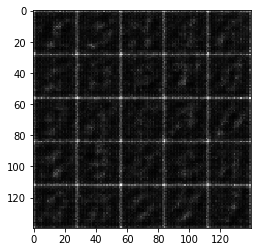

Epoch 1/2... Discriminator Loss: 1.1506... Generator Loss: 0.9718
Epoch 1/2... Discriminator Loss: 1.1141... Generator Loss: 1.0242
Epoch 1/2... Discriminator Loss: 1.1018... Generator Loss: 1.0301
Epoch 1/2... Discriminator Loss: 1.1278... Generator Loss: 0.9548
Epoch 1/2... Discriminator Loss: 1.1296... Generator Loss: 0.9675
Epoch 1/2... Discriminator Loss: 1.1309... Generator Loss: 1.0600
Epoch 1/2... Discriminator Loss: 1.1874... Generator Loss: 0.9849
Epoch 1/2... Discriminator Loss: 1.1505... Generator Loss: 0.9791
Epoch 1/2... Discriminator Loss: 1.1518... Generator Loss: 0.9401
Epoch 1/2... Discriminator Loss: 1.1870... Generator Loss: 1.0125
Epoch 1/2... Discriminator Loss: 1.1094... Generator Loss: 1.0577
Epoch 1/2... Discriminator Loss: 1.1140... Generator Loss: 1.0544
Epoch 1/2... Discriminator Loss: 1.1952... Generator Loss: 0.9863
Epoch 1/2... Discriminator Loss: 1.1923... Generator Loss: 0.9472
Epoch 1/2... Discriminator Loss: 1.1327... Generator Loss: 0.9818


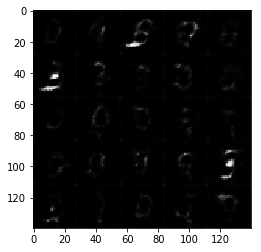

Epoch 1/2... Discriminator Loss: 1.1210... Generator Loss: 1.0394
Epoch 1/2... Discriminator Loss: 1.2397... Generator Loss: 1.0535
Epoch 1/2... Discriminator Loss: 1.1220... Generator Loss: 1.0565
Epoch 1/2... Discriminator Loss: 1.1543... Generator Loss: 0.9748
Epoch 1/2... Discriminator Loss: 1.0926... Generator Loss: 1.0261
Epoch 1/2... Discriminator Loss: 1.1488... Generator Loss: 1.0363
Epoch 1/2... Discriminator Loss: 1.1052... Generator Loss: 1.1146
Epoch 1/2... Discriminator Loss: 1.0241... Generator Loss: 1.1599
Epoch 1/2... Discriminator Loss: 1.2362... Generator Loss: 1.0258
Epoch 1/2... Discriminator Loss: 1.1299... Generator Loss: 0.9942
Epoch 1/2... Discriminator Loss: 1.0831... Generator Loss: 1.0710
Epoch 1/2... Discriminator Loss: 1.1628... Generator Loss: 1.0405
Epoch 1/2... Discriminator Loss: 1.1519... Generator Loss: 0.9973
Epoch 1/2... Discriminator Loss: 1.1551... Generator Loss: 0.9475
Epoch 1/2... Discriminator Loss: 1.1006... Generator Loss: 1.1420


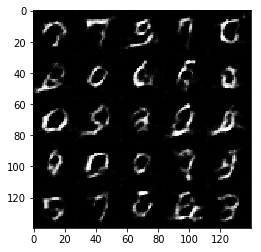

Epoch 1/2... Discriminator Loss: 1.1189... Generator Loss: 0.9929
Epoch 1/2... Discriminator Loss: 1.1354... Generator Loss: 1.0805
Epoch 1/2... Discriminator Loss: 1.1036... Generator Loss: 0.9703
Epoch 1/2... Discriminator Loss: 1.1591... Generator Loss: 0.9380
Epoch 1/2... Discriminator Loss: 1.1404... Generator Loss: 0.9711
Epoch 1/2... Discriminator Loss: 1.1785... Generator Loss: 0.9809
Epoch 1/2... Discriminator Loss: 1.0477... Generator Loss: 1.0779
Epoch 1/2... Discriminator Loss: 1.0829... Generator Loss: 1.0545
Epoch 1/2... Discriminator Loss: 1.0497... Generator Loss: 1.0279
Epoch 1/2... Discriminator Loss: 1.1267... Generator Loss: 1.1505
Epoch 1/2... Discriminator Loss: 1.2392... Generator Loss: 0.9357
Epoch 1/2... Discriminator Loss: 1.2670... Generator Loss: 1.0741
Epoch 1/2... Discriminator Loss: 1.1619... Generator Loss: 1.0115
Epoch 1/2... Discriminator Loss: 1.0669... Generator Loss: 1.0313
Epoch 1/2... Discriminator Loss: 1.0748... Generator Loss: 1.0968


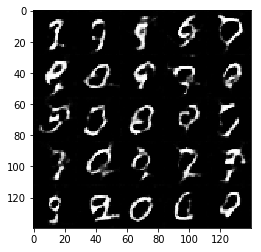

Epoch 1/2... Discriminator Loss: 1.1741... Generator Loss: 0.9948
Epoch 1/2... Discriminator Loss: 1.1446... Generator Loss: 1.0449
Epoch 1/2... Discriminator Loss: 1.0567... Generator Loss: 1.0929
Epoch 1/2... Discriminator Loss: 1.2672... Generator Loss: 1.0679
Epoch 1/2... Discriminator Loss: 1.1897... Generator Loss: 0.9610
Epoch 1/2... Discriminator Loss: 1.1865... Generator Loss: 1.0063
Epoch 1/2... Discriminator Loss: 1.1652... Generator Loss: 0.9045
Epoch 1/2... Discriminator Loss: 1.2047... Generator Loss: 0.9444
Epoch 1/2... Discriminator Loss: 1.1241... Generator Loss: 1.0438
Epoch 1/2... Discriminator Loss: 1.1137... Generator Loss: 0.9747
Epoch 1/2... Discriminator Loss: 1.1536... Generator Loss: 1.0679
Epoch 1/2... Discriminator Loss: 1.0533... Generator Loss: 1.0468
Epoch 1/2... Discriminator Loss: 1.1994... Generator Loss: 0.9268
Epoch 1/2... Discriminator Loss: 1.1178... Generator Loss: 1.0603
Epoch 1/2... Discriminator Loss: 1.1288... Generator Loss: 1.0608


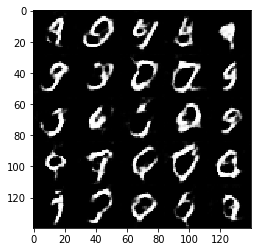

Epoch 1/2... Discriminator Loss: 1.0324... Generator Loss: 1.0919
Epoch 1/2... Discriminator Loss: 1.1059... Generator Loss: 1.0387
Epoch 1/2... Discriminator Loss: 1.2492... Generator Loss: 0.8969
Epoch 1/2... Discriminator Loss: 1.1782... Generator Loss: 0.9492
Epoch 1/2... Discriminator Loss: 1.3071... Generator Loss: 1.2020
Epoch 1/2... Discriminator Loss: 1.0804... Generator Loss: 1.0593
Epoch 1/2... Discriminator Loss: 1.1154... Generator Loss: 1.0067
Epoch 1/2... Discriminator Loss: 1.0854... Generator Loss: 1.1863
Epoch 1/2... Discriminator Loss: 1.0625... Generator Loss: 1.0288
Epoch 1/2... Discriminator Loss: 1.2232... Generator Loss: 1.0977
Epoch 1/2... Discriminator Loss: 1.6095... Generator Loss: 0.8528
Epoch 1/2... Discriminator Loss: 1.2599... Generator Loss: 0.7793
Epoch 1/2... Discriminator Loss: 1.1595... Generator Loss: 0.9645
Epoch 1/2... Discriminator Loss: 1.1330... Generator Loss: 0.9779
Epoch 1/2... Discriminator Loss: 1.0703... Generator Loss: 1.0908


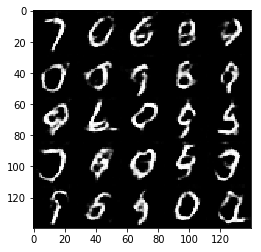

Epoch 1/2... Discriminator Loss: 1.1577... Generator Loss: 1.0830
Epoch 1/2... Discriminator Loss: 1.0986... Generator Loss: 1.0917
Epoch 1/2... Discriminator Loss: 1.1241... Generator Loss: 0.9676
Epoch 2/2... Discriminator Loss: 1.1031... Generator Loss: 1.0172
Epoch 2/2... Discriminator Loss: 1.1198... Generator Loss: 1.0348
Epoch 2/2... Discriminator Loss: 1.0845... Generator Loss: 1.0780
Epoch 2/2... Discriminator Loss: 1.1770... Generator Loss: 0.9897
Epoch 2/2... Discriminator Loss: 1.1619... Generator Loss: 0.9737
Epoch 2/2... Discriminator Loss: 1.1655... Generator Loss: 1.0192
Epoch 2/2... Discriminator Loss: 1.3915... Generator Loss: 1.3368
Epoch 2/2... Discriminator Loss: 1.0876... Generator Loss: 1.1201
Epoch 2/2... Discriminator Loss: 1.0190... Generator Loss: 1.0976
Epoch 2/2... Discriminator Loss: 1.1170... Generator Loss: 1.0173
Epoch 2/2... Discriminator Loss: 1.1806... Generator Loss: 0.8901
Epoch 2/2... Discriminator Loss: 1.1374... Generator Loss: 1.0438


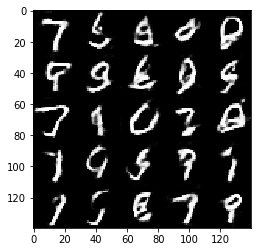

Epoch 2/2... Discriminator Loss: 1.1584... Generator Loss: 1.0348
Epoch 2/2... Discriminator Loss: 1.0954... Generator Loss: 1.0211
Epoch 2/2... Discriminator Loss: 1.1582... Generator Loss: 0.9852
Epoch 2/2... Discriminator Loss: 1.2048... Generator Loss: 0.9446
Epoch 2/2... Discriminator Loss: 1.1262... Generator Loss: 1.0603
Epoch 2/2... Discriminator Loss: 1.0828... Generator Loss: 1.0514
Epoch 2/2... Discriminator Loss: 1.1291... Generator Loss: 0.9916
Epoch 2/2... Discriminator Loss: 1.1759... Generator Loss: 0.9912
Epoch 2/2... Discriminator Loss: 1.1353... Generator Loss: 0.9344
Epoch 2/2... Discriminator Loss: 1.1853... Generator Loss: 0.8719
Epoch 2/2... Discriminator Loss: 1.1305... Generator Loss: 0.9786
Epoch 2/2... Discriminator Loss: 1.1989... Generator Loss: 1.2233
Epoch 2/2... Discriminator Loss: 1.1390... Generator Loss: 0.9704
Epoch 2/2... Discriminator Loss: 1.1414... Generator Loss: 1.0797
Epoch 2/2... Discriminator Loss: 1.1654... Generator Loss: 1.0378


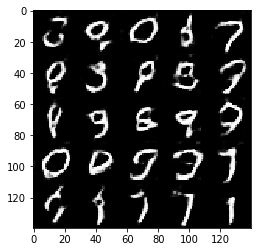

Epoch 2/2... Discriminator Loss: 1.0922... Generator Loss: 1.1604
Epoch 2/2... Discriminator Loss: 1.1527... Generator Loss: 0.9305
Epoch 2/2... Discriminator Loss: 1.1842... Generator Loss: 0.9689
Epoch 2/2... Discriminator Loss: 1.1083... Generator Loss: 1.0157
Epoch 2/2... Discriminator Loss: 1.1414... Generator Loss: 1.0169
Epoch 2/2... Discriminator Loss: 1.2237... Generator Loss: 1.1846
Epoch 2/2... Discriminator Loss: 1.1262... Generator Loss: 1.0204
Epoch 2/2... Discriminator Loss: 1.1255... Generator Loss: 0.9054
Epoch 2/2... Discriminator Loss: 1.1380... Generator Loss: 0.9209
Epoch 2/2... Discriminator Loss: 1.2474... Generator Loss: 1.1639
Epoch 2/2... Discriminator Loss: 1.1118... Generator Loss: 1.0426
Epoch 2/2... Discriminator Loss: 1.2161... Generator Loss: 0.8841
Epoch 2/2... Discriminator Loss: 1.1499... Generator Loss: 1.0593
Epoch 2/2... Discriminator Loss: 1.1220... Generator Loss: 1.0331
Epoch 2/2... Discriminator Loss: 1.4138... Generator Loss: 0.6063


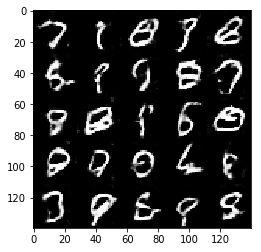

Epoch 2/2... Discriminator Loss: 1.1729... Generator Loss: 0.8946
Epoch 2/2... Discriminator Loss: 1.0924... Generator Loss: 1.0453
Epoch 2/2... Discriminator Loss: 1.1750... Generator Loss: 1.1149
Epoch 2/2... Discriminator Loss: 1.1228... Generator Loss: 1.1574
Epoch 2/2... Discriminator Loss: 1.2479... Generator Loss: 1.0113
Epoch 2/2... Discriminator Loss: 1.1141... Generator Loss: 1.1405
Epoch 2/2... Discriminator Loss: 1.1817... Generator Loss: 1.0648
Epoch 2/2... Discriminator Loss: 1.1760... Generator Loss: 0.9610
Epoch 2/2... Discriminator Loss: 1.1395... Generator Loss: 1.0695
Epoch 2/2... Discriminator Loss: 1.1954... Generator Loss: 0.9287
Epoch 2/2... Discriminator Loss: 1.1456... Generator Loss: 1.0765
Epoch 2/2... Discriminator Loss: 1.1380... Generator Loss: 1.0018
Epoch 2/2... Discriminator Loss: 1.1212... Generator Loss: 1.0314
Epoch 2/2... Discriminator Loss: 1.1606... Generator Loss: 0.9046
Epoch 2/2... Discriminator Loss: 1.2292... Generator Loss: 1.1240


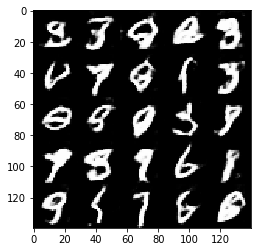

Epoch 2/2... Discriminator Loss: 1.1566... Generator Loss: 1.0328
Epoch 2/2... Discriminator Loss: 1.1159... Generator Loss: 0.9907
Epoch 2/2... Discriminator Loss: 1.0657... Generator Loss: 1.1459
Epoch 2/2... Discriminator Loss: 1.1022... Generator Loss: 1.0726
Epoch 2/2... Discriminator Loss: 1.1073... Generator Loss: 1.0458
Epoch 2/2... Discriminator Loss: 1.1159... Generator Loss: 1.0782
Epoch 2/2... Discriminator Loss: 1.1800... Generator Loss: 1.0022
Epoch 2/2... Discriminator Loss: 1.2117... Generator Loss: 1.2206
Epoch 2/2... Discriminator Loss: 1.1093... Generator Loss: 1.0430
Epoch 2/2... Discriminator Loss: 1.1941... Generator Loss: 0.9636
Epoch 2/2... Discriminator Loss: 1.2188... Generator Loss: 0.8101
Epoch 2/2... Discriminator Loss: 1.1229... Generator Loss: 0.9458
Epoch 2/2... Discriminator Loss: 1.2099... Generator Loss: 0.8945
Epoch 2/2... Discriminator Loss: 1.1219... Generator Loss: 0.9785
Epoch 2/2... Discriminator Loss: 1.1477... Generator Loss: 1.1478


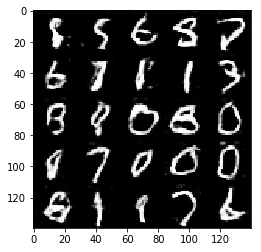

Epoch 2/2... Discriminator Loss: 1.1276... Generator Loss: 1.0450
Epoch 2/2... Discriminator Loss: 1.1406... Generator Loss: 1.0592
Epoch 2/2... Discriminator Loss: 1.1233... Generator Loss: 1.0826
Epoch 2/2... Discriminator Loss: 1.1217... Generator Loss: 1.0298
Epoch 2/2... Discriminator Loss: 1.1319... Generator Loss: 0.9184
Epoch 2/2... Discriminator Loss: 1.3670... Generator Loss: 0.7860
Epoch 2/2... Discriminator Loss: 1.2070... Generator Loss: 0.8834
Epoch 2/2... Discriminator Loss: 1.4494... Generator Loss: 1.1183
Epoch 2/2... Discriminator Loss: 1.1545... Generator Loss: 0.9763
Epoch 2/2... Discriminator Loss: 1.1388... Generator Loss: 0.9719
Epoch 2/2... Discriminator Loss: 1.0994... Generator Loss: 0.9605
Epoch 2/2... Discriminator Loss: 1.0997... Generator Loss: 1.0567
Epoch 2/2... Discriminator Loss: 1.1885... Generator Loss: 0.9489
Epoch 2/2... Discriminator Loss: 1.0813... Generator Loss: 1.1234
Epoch 2/2... Discriminator Loss: 1.4909... Generator Loss: 1.3652


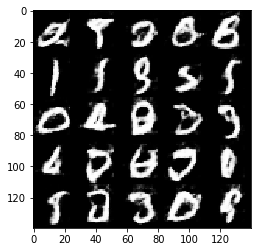

Epoch 2/2... Discriminator Loss: 1.3192... Generator Loss: 0.8019
Epoch 2/2... Discriminator Loss: 1.1929... Generator Loss: 0.9481
Epoch 2/2... Discriminator Loss: 1.1473... Generator Loss: 1.0090
Epoch 2/2... Discriminator Loss: 1.1324... Generator Loss: 1.0158
Epoch 2/2... Discriminator Loss: 1.1224... Generator Loss: 1.0380
Epoch 2/2... Discriminator Loss: 1.1472... Generator Loss: 0.9774
Epoch 2/2... Discriminator Loss: 1.0883... Generator Loss: 1.0404


In [18]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.3182... Generator Loss: 0.8409
Epoch 1/1... Discriminator Loss: 1.1664... Generator Loss: 0.9698
Epoch 1/1... Discriminator Loss: 1.0773... Generator Loss: 1.0766
Epoch 1/1... Discriminator Loss: 0.9030... Generator Loss: 1.2909
Epoch 1/1... Discriminator Loss: 0.8855... Generator Loss: 1.3184
Epoch 1/1... Discriminator Loss: 0.8325... Generator Loss: 1.4071
Epoch 1/1... Discriminator Loss: 0.7434... Generator Loss: 1.5433
Epoch 1/1... Discriminator Loss: 0.7392... Generator Loss: 1.6081
Epoch 1/1... Discriminator Loss: 0.6734... Generator Loss: 1.6875
Epoch 1/1... Discriminator Loss: 0.6855... Generator Loss: 1.6621
Epoch 1/1... Discriminator Loss: 0.6678... Generator Loss: 1.6656
Epoch 1/1... Discriminator Loss: 0.6207... Generator Loss: 1.8837
Epoch 1/1... Discriminator Loss: 0.5735... Generator Loss: 2.0484
Epoch 1/1... Discriminator Loss: 0.5972... Generator Loss: 1.9082
Epoch 1/1... Discriminator Loss: 0.6331... Generator Loss: 1.7678


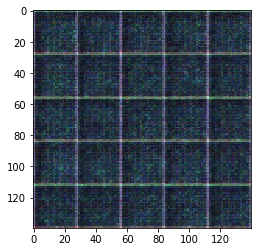

Epoch 1/1... Discriminator Loss: 0.5039... Generator Loss: 2.2888
Epoch 1/1... Discriminator Loss: 0.4406... Generator Loss: 2.6644
Epoch 1/1... Discriminator Loss: 0.4221... Generator Loss: 2.7267
Epoch 1/1... Discriminator Loss: 0.4142... Generator Loss: 2.8185
Epoch 1/1... Discriminator Loss: 0.4215... Generator Loss: 2.7700
Epoch 1/1... Discriminator Loss: 0.4794... Generator Loss: 2.2476
Epoch 1/1... Discriminator Loss: 0.6886... Generator Loss: 2.3770
Epoch 1/1... Discriminator Loss: 0.4445... Generator Loss: 2.6397
Epoch 1/1... Discriminator Loss: 0.4608... Generator Loss: 2.4064
Epoch 1/1... Discriminator Loss: 0.5067... Generator Loss: 2.2752
Epoch 1/1... Discriminator Loss: 0.5266... Generator Loss: 2.2350
Epoch 1/1... Discriminator Loss: 0.5351... Generator Loss: 2.1453
Epoch 1/1... Discriminator Loss: 0.5022... Generator Loss: 2.3023
Epoch 1/1... Discriminator Loss: 0.4941... Generator Loss: 2.3590
Epoch 1/1... Discriminator Loss: 0.5048... Generator Loss: 2.2327


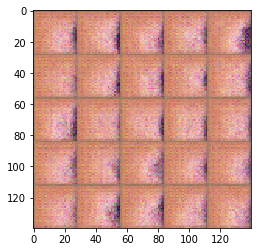

Epoch 1/1... Discriminator Loss: 0.5267... Generator Loss: 2.2078
Epoch 1/1... Discriminator Loss: 0.5128... Generator Loss: 2.2059
Epoch 1/1... Discriminator Loss: 0.4955... Generator Loss: 2.2686
Epoch 1/1... Discriminator Loss: 0.4838... Generator Loss: 2.3921
Epoch 1/1... Discriminator Loss: 0.4890... Generator Loss: 2.2782
Epoch 1/1... Discriminator Loss: 0.5559... Generator Loss: 2.1090
Epoch 1/1... Discriminator Loss: 0.5173... Generator Loss: 2.1616
Epoch 1/1... Discriminator Loss: 0.5219... Generator Loss: 2.1531
Epoch 1/1... Discriminator Loss: 0.5230... Generator Loss: 2.1862
Epoch 1/1... Discriminator Loss: 0.5058... Generator Loss: 2.3471
Epoch 1/1... Discriminator Loss: 0.5157... Generator Loss: 2.0996
Epoch 1/1... Discriminator Loss: 0.6040... Generator Loss: 2.0338
Epoch 1/1... Discriminator Loss: 0.6043... Generator Loss: 1.9094
Epoch 1/1... Discriminator Loss: 0.5685... Generator Loss: 2.0621
Epoch 1/1... Discriminator Loss: 0.6224... Generator Loss: 1.9236


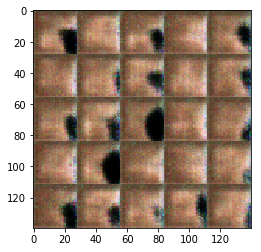

Epoch 1/1... Discriminator Loss: 0.6070... Generator Loss: 1.9649
Epoch 1/1... Discriminator Loss: 0.6053... Generator Loss: 1.9104
Epoch 1/1... Discriminator Loss: 0.5714... Generator Loss: 1.9931
Epoch 1/1... Discriminator Loss: 0.6715... Generator Loss: 1.8591
Epoch 1/1... Discriminator Loss: 0.5890... Generator Loss: 1.9678
Epoch 1/1... Discriminator Loss: 0.5913... Generator Loss: 1.8885
Epoch 1/1... Discriminator Loss: 0.6021... Generator Loss: 1.8431
Epoch 1/1... Discriminator Loss: 0.6240... Generator Loss: 1.7834
Epoch 1/1... Discriminator Loss: 0.6238... Generator Loss: 1.7634
Epoch 1/1... Discriminator Loss: 0.6025... Generator Loss: 1.9428
Epoch 1/1... Discriminator Loss: 0.6754... Generator Loss: 1.7583
Epoch 1/1... Discriminator Loss: 0.6531... Generator Loss: 1.6913
Epoch 1/1... Discriminator Loss: 0.6769... Generator Loss: 1.6505
Epoch 1/1... Discriminator Loss: 0.6651... Generator Loss: 1.6516
Epoch 1/1... Discriminator Loss: 0.6673... Generator Loss: 1.6753


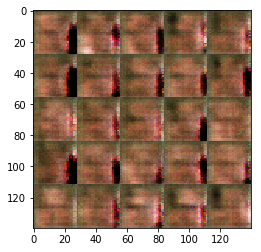

Epoch 1/1... Discriminator Loss: 0.6611... Generator Loss: 1.7005
Epoch 1/1... Discriminator Loss: 0.7016... Generator Loss: 1.7065
Epoch 1/1... Discriminator Loss: 0.6469... Generator Loss: 1.7613
Epoch 1/1... Discriminator Loss: 0.7693... Generator Loss: 1.4553
Epoch 1/1... Discriminator Loss: 0.7478... Generator Loss: 1.5897
Epoch 1/1... Discriminator Loss: 0.7316... Generator Loss: 1.5543
Epoch 1/1... Discriminator Loss: 0.6978... Generator Loss: 1.5417
Epoch 1/1... Discriminator Loss: 0.9831... Generator Loss: 1.6362
Epoch 1/1... Discriminator Loss: 0.8045... Generator Loss: 1.2929
Epoch 1/1... Discriminator Loss: 0.7992... Generator Loss: 1.3958
Epoch 1/1... Discriminator Loss: 0.7758... Generator Loss: 1.4919
Epoch 1/1... Discriminator Loss: 0.7359... Generator Loss: 1.6099
Epoch 1/1... Discriminator Loss: 0.7396... Generator Loss: 1.5820
Epoch 1/1... Discriminator Loss: 0.7747... Generator Loss: 1.4636
Epoch 1/1... Discriminator Loss: 0.8295... Generator Loss: 1.3975


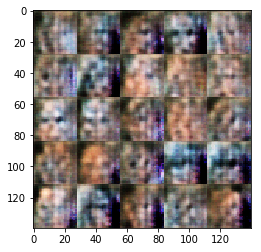

Epoch 1/1... Discriminator Loss: 0.7614... Generator Loss: 1.5132
Epoch 1/1... Discriminator Loss: 0.8277... Generator Loss: 1.4031
Epoch 1/1... Discriminator Loss: 0.8348... Generator Loss: 1.3220
Epoch 1/1... Discriminator Loss: 0.8000... Generator Loss: 1.4513
Epoch 1/1... Discriminator Loss: 0.8767... Generator Loss: 1.4031
Epoch 1/1... Discriminator Loss: 0.8887... Generator Loss: 1.2109
Epoch 1/1... Discriminator Loss: 0.8595... Generator Loss: 1.2793
Epoch 1/1... Discriminator Loss: 0.9182... Generator Loss: 1.2185
Epoch 1/1... Discriminator Loss: 0.8752... Generator Loss: 1.3162
Epoch 1/1... Discriminator Loss: 0.8756... Generator Loss: 1.3281
Epoch 1/1... Discriminator Loss: 0.9050... Generator Loss: 1.2247
Epoch 1/1... Discriminator Loss: 0.8199... Generator Loss: 1.3767
Epoch 1/1... Discriminator Loss: 0.9612... Generator Loss: 1.3904
Epoch 1/1... Discriminator Loss: 0.9243... Generator Loss: 1.2994
Epoch 1/1... Discriminator Loss: 0.9692... Generator Loss: 1.1464


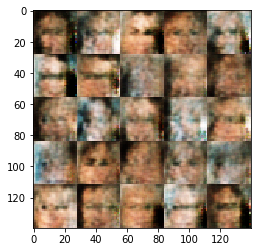

Epoch 1/1... Discriminator Loss: 0.9032... Generator Loss: 1.3875
Epoch 1/1... Discriminator Loss: 0.9165... Generator Loss: 1.2824
Epoch 1/1... Discriminator Loss: 0.9812... Generator Loss: 1.1059
Epoch 1/1... Discriminator Loss: 0.8516... Generator Loss: 1.3811
Epoch 1/1... Discriminator Loss: 0.9372... Generator Loss: 1.2903
Epoch 1/1... Discriminator Loss: 0.9786... Generator Loss: 1.1965
Epoch 1/1... Discriminator Loss: 0.9593... Generator Loss: 1.2437
Epoch 1/1... Discriminator Loss: 0.9063... Generator Loss: 1.3145
Epoch 1/1... Discriminator Loss: 0.9819... Generator Loss: 1.2046
Epoch 1/1... Discriminator Loss: 0.9855... Generator Loss: 1.2176
Epoch 1/1... Discriminator Loss: 0.9828... Generator Loss: 1.1222
Epoch 1/1... Discriminator Loss: 1.0081... Generator Loss: 1.1404
Epoch 1/1... Discriminator Loss: 1.0274... Generator Loss: 1.1783
Epoch 1/1... Discriminator Loss: 1.0158... Generator Loss: 1.1297
Epoch 1/1... Discriminator Loss: 1.0378... Generator Loss: 1.1377


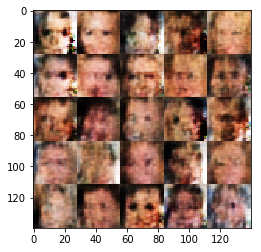

Epoch 1/1... Discriminator Loss: 0.9849... Generator Loss: 1.1840
Epoch 1/1... Discriminator Loss: 1.0404... Generator Loss: 1.1079
Epoch 1/1... Discriminator Loss: 1.0428... Generator Loss: 1.1505
Epoch 1/1... Discriminator Loss: 1.0448... Generator Loss: 1.0888
Epoch 1/1... Discriminator Loss: 1.0223... Generator Loss: 1.1856
Epoch 1/1... Discriminator Loss: 1.0502... Generator Loss: 1.1493
Epoch 1/1... Discriminator Loss: 1.0239... Generator Loss: 1.1532
Epoch 1/1... Discriminator Loss: 1.0799... Generator Loss: 1.0064
Epoch 1/1... Discriminator Loss: 1.0642... Generator Loss: 1.0729
Epoch 1/1... Discriminator Loss: 1.0436... Generator Loss: 1.0390
Epoch 1/1... Discriminator Loss: 1.8219... Generator Loss: 2.2067
Epoch 1/1... Discriminator Loss: 1.0797... Generator Loss: 1.0486
Epoch 1/1... Discriminator Loss: 1.1170... Generator Loss: 1.0944
Epoch 1/1... Discriminator Loss: 1.1176... Generator Loss: 0.9621
Epoch 1/1... Discriminator Loss: 1.0602... Generator Loss: 1.0747


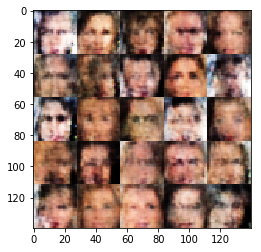

Epoch 1/1... Discriminator Loss: 1.1274... Generator Loss: 1.1106
Epoch 1/1... Discriminator Loss: 1.0963... Generator Loss: 1.0364
Epoch 1/1... Discriminator Loss: 1.1174... Generator Loss: 1.0009
Epoch 1/1... Discriminator Loss: 1.0867... Generator Loss: 1.0993
Epoch 1/1... Discriminator Loss: 1.0924... Generator Loss: 1.0534
Epoch 1/1... Discriminator Loss: 1.1304... Generator Loss: 0.9695
Epoch 1/1... Discriminator Loss: 1.1016... Generator Loss: 1.0424
Epoch 1/1... Discriminator Loss: 1.1066... Generator Loss: 1.0291
Epoch 1/1... Discriminator Loss: 1.0920... Generator Loss: 1.0591
Epoch 1/1... Discriminator Loss: 1.1470... Generator Loss: 1.0166
Epoch 1/1... Discriminator Loss: 1.0916... Generator Loss: 1.1045
Epoch 1/1... Discriminator Loss: 1.0985... Generator Loss: 1.0777
Epoch 1/1... Discriminator Loss: 1.0988... Generator Loss: 1.1252
Epoch 1/1... Discriminator Loss: 1.1271... Generator Loss: 0.9868
Epoch 1/1... Discriminator Loss: 1.1110... Generator Loss: 1.0062


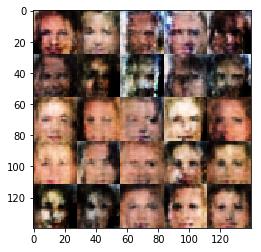

Epoch 1/1... Discriminator Loss: 1.1235... Generator Loss: 1.0631
Epoch 1/1... Discriminator Loss: 1.1194... Generator Loss: 1.0384
Epoch 1/1... Discriminator Loss: 1.1537... Generator Loss: 1.0094
Epoch 1/1... Discriminator Loss: 1.1267... Generator Loss: 1.0247
Epoch 1/1... Discriminator Loss: 1.0771... Generator Loss: 0.9916
Epoch 1/1... Discriminator Loss: 1.1457... Generator Loss: 1.1298
Epoch 1/1... Discriminator Loss: 1.1203... Generator Loss: 0.9793
Epoch 1/1... Discriminator Loss: 1.1264... Generator Loss: 1.0299
Epoch 1/1... Discriminator Loss: 1.1913... Generator Loss: 0.9839
Epoch 1/1... Discriminator Loss: 1.1182... Generator Loss: 1.0271
Epoch 1/1... Discriminator Loss: 1.1154... Generator Loss: 0.9975
Epoch 1/1... Discriminator Loss: 1.1690... Generator Loss: 0.9527
Epoch 1/1... Discriminator Loss: 1.1638... Generator Loss: 0.9290
Epoch 1/1... Discriminator Loss: 1.1262... Generator Loss: 1.0150
Epoch 1/1... Discriminator Loss: 1.1357... Generator Loss: 1.0275


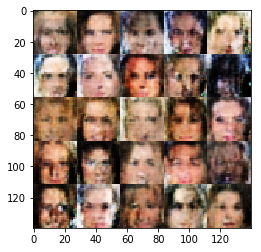

Epoch 1/1... Discriminator Loss: 1.1227... Generator Loss: 0.9876
Epoch 1/1... Discriminator Loss: 1.1635... Generator Loss: 0.9944
Epoch 1/1... Discriminator Loss: 1.0759... Generator Loss: 1.0876
Epoch 1/1... Discriminator Loss: 1.1540... Generator Loss: 1.0051
Epoch 1/1... Discriminator Loss: 1.1455... Generator Loss: 0.9365
Epoch 1/1... Discriminator Loss: 1.1172... Generator Loss: 1.0043
Epoch 1/1... Discriminator Loss: 1.1242... Generator Loss: 0.9783
Epoch 1/1... Discriminator Loss: 1.1567... Generator Loss: 1.0859
Epoch 1/1... Discriminator Loss: 1.1482... Generator Loss: 1.0378
Epoch 1/1... Discriminator Loss: 1.1301... Generator Loss: 1.1019
Epoch 1/1... Discriminator Loss: 1.1506... Generator Loss: 1.0525
Epoch 1/1... Discriminator Loss: 1.1933... Generator Loss: 0.9110
Epoch 1/1... Discriminator Loss: 1.1379... Generator Loss: 1.0590
Epoch 1/1... Discriminator Loss: 1.1719... Generator Loss: 0.9877
Epoch 1/1... Discriminator Loss: 1.1435... Generator Loss: 1.0648


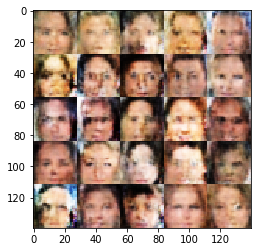

Epoch 1/1... Discriminator Loss: 1.1339... Generator Loss: 1.0426
Epoch 1/1... Discriminator Loss: 1.1531... Generator Loss: 1.0170
Epoch 1/1... Discriminator Loss: 1.1736... Generator Loss: 0.9869
Epoch 1/1... Discriminator Loss: 1.1616... Generator Loss: 0.9008
Epoch 1/1... Discriminator Loss: 1.1314... Generator Loss: 1.0325
Epoch 1/1... Discriminator Loss: 1.1750... Generator Loss: 1.0042
Epoch 1/1... Discriminator Loss: 1.1651... Generator Loss: 0.9810
Epoch 1/1... Discriminator Loss: 1.1663... Generator Loss: 0.9773
Epoch 1/1... Discriminator Loss: 1.1424... Generator Loss: 1.0132
Epoch 1/1... Discriminator Loss: 1.1896... Generator Loss: 1.0188
Epoch 1/1... Discriminator Loss: 1.1659... Generator Loss: 1.0291
Epoch 1/1... Discriminator Loss: 1.1766... Generator Loss: 0.8978
Epoch 1/1... Discriminator Loss: 1.1588... Generator Loss: 0.9943
Epoch 1/1... Discriminator Loss: 1.2339... Generator Loss: 0.8266
Epoch 1/1... Discriminator Loss: 1.1954... Generator Loss: 0.8495


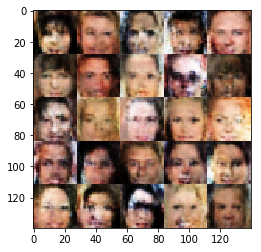

Epoch 1/1... Discriminator Loss: 1.1254... Generator Loss: 0.9953
Epoch 1/1... Discriminator Loss: 1.2148... Generator Loss: 0.9574
Epoch 1/1... Discriminator Loss: 1.1716... Generator Loss: 1.0045
Epoch 1/1... Discriminator Loss: 1.1645... Generator Loss: 1.0624
Epoch 1/1... Discriminator Loss: 1.2062... Generator Loss: 1.0314
Epoch 1/1... Discriminator Loss: 1.1824... Generator Loss: 0.9594
Epoch 1/1... Discriminator Loss: 1.1831... Generator Loss: 0.9898
Epoch 1/1... Discriminator Loss: 1.2166... Generator Loss: 0.9953
Epoch 1/1... Discriminator Loss: 1.1181... Generator Loss: 1.0117
Epoch 1/1... Discriminator Loss: 1.1555... Generator Loss: 1.0582
Epoch 1/1... Discriminator Loss: 1.2221... Generator Loss: 1.0114
Epoch 1/1... Discriminator Loss: 1.1594... Generator Loss: 0.9064
Epoch 1/1... Discriminator Loss: 1.1568... Generator Loss: 1.0113
Epoch 1/1... Discriminator Loss: 1.1676... Generator Loss: 0.9915
Epoch 1/1... Discriminator Loss: 1.1931... Generator Loss: 0.9999


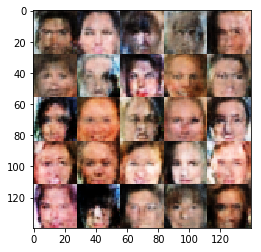

Epoch 1/1... Discriminator Loss: 1.1758... Generator Loss: 0.9484
Epoch 1/1... Discriminator Loss: 1.1543... Generator Loss: 0.9408
Epoch 1/1... Discriminator Loss: 1.2370... Generator Loss: 1.0044
Epoch 1/1... Discriminator Loss: 1.1754... Generator Loss: 0.9935
Epoch 1/1... Discriminator Loss: 1.1655... Generator Loss: 1.0016
Epoch 1/1... Discriminator Loss: 1.1650... Generator Loss: 0.9643
Epoch 1/1... Discriminator Loss: 1.1500... Generator Loss: 1.0255
Epoch 1/1... Discriminator Loss: 1.1679... Generator Loss: 1.0441
Epoch 1/1... Discriminator Loss: 1.1894... Generator Loss: 1.0153
Epoch 1/1... Discriminator Loss: 1.1150... Generator Loss: 0.9822
Epoch 1/1... Discriminator Loss: 1.1977... Generator Loss: 0.9053
Epoch 1/1... Discriminator Loss: 1.2407... Generator Loss: 0.8840
Epoch 1/1... Discriminator Loss: 1.1674... Generator Loss: 0.9932
Epoch 1/1... Discriminator Loss: 1.2196... Generator Loss: 0.9875
Epoch 1/1... Discriminator Loss: 1.3014... Generator Loss: 1.0198


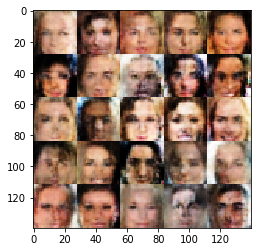

Epoch 1/1... Discriminator Loss: 1.1913... Generator Loss: 0.9299
Epoch 1/1... Discriminator Loss: 1.1752... Generator Loss: 0.9380
Epoch 1/1... Discriminator Loss: 1.2519... Generator Loss: 0.9180
Epoch 1/1... Discriminator Loss: 1.1761... Generator Loss: 0.9661
Epoch 1/1... Discriminator Loss: 1.1931... Generator Loss: 0.9017
Epoch 1/1... Discriminator Loss: 1.2246... Generator Loss: 0.9739
Epoch 1/1... Discriminator Loss: 1.1685... Generator Loss: 1.0212
Epoch 1/1... Discriminator Loss: 1.1922... Generator Loss: 0.9641
Epoch 1/1... Discriminator Loss: 1.2029... Generator Loss: 0.9206
Epoch 1/1... Discriminator Loss: 1.2389... Generator Loss: 0.9356
Epoch 1/1... Discriminator Loss: 1.1561... Generator Loss: 1.0396
Epoch 1/1... Discriminator Loss: 1.1969... Generator Loss: 0.9441
Epoch 1/1... Discriminator Loss: 1.2105... Generator Loss: 0.8736
Epoch 1/1... Discriminator Loss: 1.2207... Generator Loss: 1.0121
Epoch 1/1... Discriminator Loss: 1.2277... Generator Loss: 0.9408


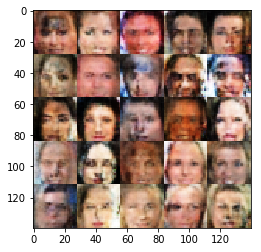

Epoch 1/1... Discriminator Loss: 1.2055... Generator Loss: 0.9436
Epoch 1/1... Discriminator Loss: 1.1901... Generator Loss: 0.9300
Epoch 1/1... Discriminator Loss: 1.2026... Generator Loss: 1.0465
Epoch 1/1... Discriminator Loss: 1.2143... Generator Loss: 0.9516
Epoch 1/1... Discriminator Loss: 1.1555... Generator Loss: 1.0052
Epoch 1/1... Discriminator Loss: 1.2166... Generator Loss: 0.9834
Epoch 1/1... Discriminator Loss: 1.2328... Generator Loss: 0.8509
Epoch 1/1... Discriminator Loss: 1.1937... Generator Loss: 1.0988
Epoch 1/1... Discriminator Loss: 1.1984... Generator Loss: 0.9772
Epoch 1/1... Discriminator Loss: 1.2029... Generator Loss: 0.9912
Epoch 1/1... Discriminator Loss: 1.1443... Generator Loss: 0.9901
Epoch 1/1... Discriminator Loss: 1.1736... Generator Loss: 1.0360
Epoch 1/1... Discriminator Loss: 1.1689... Generator Loss: 0.9923
Epoch 1/1... Discriminator Loss: 1.1802... Generator Loss: 0.8917
Epoch 1/1... Discriminator Loss: 1.1642... Generator Loss: 1.0341


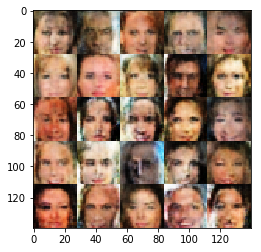

Epoch 1/1... Discriminator Loss: 1.1565... Generator Loss: 1.0144
Epoch 1/1... Discriminator Loss: 1.2434... Generator Loss: 0.9011
Epoch 1/1... Discriminator Loss: 1.2303... Generator Loss: 0.8914
Epoch 1/1... Discriminator Loss: 1.1783... Generator Loss: 1.0445
Epoch 1/1... Discriminator Loss: 1.2064... Generator Loss: 0.9484
Epoch 1/1... Discriminator Loss: 1.2154... Generator Loss: 0.9709
Epoch 1/1... Discriminator Loss: 1.1853... Generator Loss: 0.9427
Epoch 1/1... Discriminator Loss: 1.1866... Generator Loss: 1.0331
Epoch 1/1... Discriminator Loss: 1.2108... Generator Loss: 0.9995
Epoch 1/1... Discriminator Loss: 1.2094... Generator Loss: 0.9361
Epoch 1/1... Discriminator Loss: 1.1874... Generator Loss: 1.0784
Epoch 1/1... Discriminator Loss: 1.2009... Generator Loss: 0.9592
Epoch 1/1... Discriminator Loss: 1.2133... Generator Loss: 0.9307
Epoch 1/1... Discriminator Loss: 1.2008... Generator Loss: 1.0098
Epoch 1/1... Discriminator Loss: 1.2409... Generator Loss: 0.9073


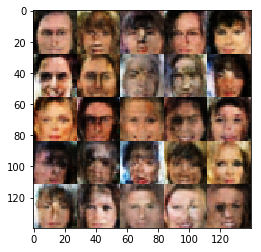

Epoch 1/1... Discriminator Loss: 1.1943... Generator Loss: 0.9172
Epoch 1/1... Discriminator Loss: 1.1932... Generator Loss: 1.0789
Epoch 1/1... Discriminator Loss: 1.2070... Generator Loss: 0.9298
Epoch 1/1... Discriminator Loss: 1.2686... Generator Loss: 0.8527
Epoch 1/1... Discriminator Loss: 1.2213... Generator Loss: 0.9284
Epoch 1/1... Discriminator Loss: 1.1778... Generator Loss: 0.9549
Epoch 1/1... Discriminator Loss: 1.1796... Generator Loss: 0.9614
Epoch 1/1... Discriminator Loss: 1.1990... Generator Loss: 0.9932
Epoch 1/1... Discriminator Loss: 1.2390... Generator Loss: 0.9036
Epoch 1/1... Discriminator Loss: 1.2044... Generator Loss: 0.8756
Epoch 1/1... Discriminator Loss: 1.1953... Generator Loss: 1.0111
Epoch 1/1... Discriminator Loss: 1.1908... Generator Loss: 0.9626
Epoch 1/1... Discriminator Loss: 1.1901... Generator Loss: 0.9446
Epoch 1/1... Discriminator Loss: 1.2463... Generator Loss: 0.9526
Epoch 1/1... Discriminator Loss: 1.2273... Generator Loss: 1.0180


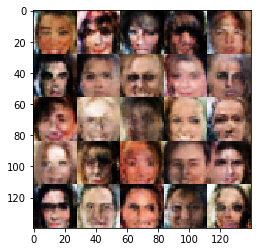

Epoch 1/1... Discriminator Loss: 1.2108... Generator Loss: 0.8801
Epoch 1/1... Discriminator Loss: 1.1999... Generator Loss: 0.8982
Epoch 1/1... Discriminator Loss: 1.2590... Generator Loss: 0.9335
Epoch 1/1... Discriminator Loss: 1.2359... Generator Loss: 0.9098
Epoch 1/1... Discriminator Loss: 1.2273... Generator Loss: 0.8815
Epoch 1/1... Discriminator Loss: 1.2178... Generator Loss: 0.8834
Epoch 1/1... Discriminator Loss: 1.1948... Generator Loss: 0.9160
Epoch 1/1... Discriminator Loss: 1.2068... Generator Loss: 0.9976
Epoch 1/1... Discriminator Loss: 1.2209... Generator Loss: 0.9664
Epoch 1/1... Discriminator Loss: 1.2296... Generator Loss: 0.8941
Epoch 1/1... Discriminator Loss: 1.2260... Generator Loss: 0.8548
Epoch 1/1... Discriminator Loss: 1.2127... Generator Loss: 0.9651
Epoch 1/1... Discriminator Loss: 1.1786... Generator Loss: 1.0035
Epoch 1/1... Discriminator Loss: 1.2422... Generator Loss: 0.9135
Epoch 1/1... Discriminator Loss: 1.1948... Generator Loss: 0.9601


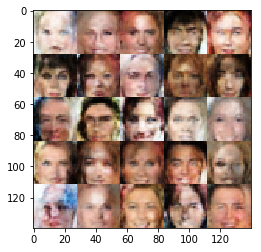

Epoch 1/1... Discriminator Loss: 1.1745... Generator Loss: 0.9747
Epoch 1/1... Discriminator Loss: 1.1876... Generator Loss: 0.9273
Epoch 1/1... Discriminator Loss: 1.1813... Generator Loss: 0.9798
Epoch 1/1... Discriminator Loss: 1.2280... Generator Loss: 0.9168
Epoch 1/1... Discriminator Loss: 1.1972... Generator Loss: 0.9935
Epoch 1/1... Discriminator Loss: 1.2360... Generator Loss: 0.9259
Epoch 1/1... Discriminator Loss: 1.2063... Generator Loss: 0.9939
Epoch 1/1... Discriminator Loss: 1.2069... Generator Loss: 0.9693
Epoch 1/1... Discriminator Loss: 1.2315... Generator Loss: 0.9210
Epoch 1/1... Discriminator Loss: 1.2252... Generator Loss: 0.8935
Epoch 1/1... Discriminator Loss: 1.1303... Generator Loss: 0.9855
Epoch 1/1... Discriminator Loss: 1.2425... Generator Loss: 0.8703
Epoch 1/1... Discriminator Loss: 1.2055... Generator Loss: 0.9326
Epoch 1/1... Discriminator Loss: 1.2165... Generator Loss: 0.8804
Epoch 1/1... Discriminator Loss: 1.2350... Generator Loss: 0.9548


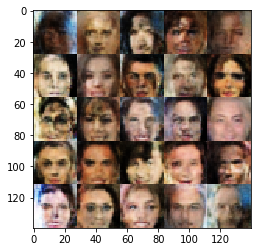

Epoch 1/1... Discriminator Loss: 1.2600... Generator Loss: 0.9159
Epoch 1/1... Discriminator Loss: 1.2616... Generator Loss: 0.8841
Epoch 1/1... Discriminator Loss: 1.2364... Generator Loss: 1.0219
Epoch 1/1... Discriminator Loss: 1.2266... Generator Loss: 0.9209
Epoch 1/1... Discriminator Loss: 1.2210... Generator Loss: 0.9052
Epoch 1/1... Discriminator Loss: 1.2226... Generator Loss: 0.9841
Epoch 1/1... Discriminator Loss: 1.2034... Generator Loss: 0.9627
Epoch 1/1... Discriminator Loss: 1.1515... Generator Loss: 1.0284
Epoch 1/1... Discriminator Loss: 1.2528... Generator Loss: 0.9029
Epoch 1/1... Discriminator Loss: 1.2456... Generator Loss: 0.8311
Epoch 1/1... Discriminator Loss: 1.2256... Generator Loss: 0.9285
Epoch 1/1... Discriminator Loss: 1.2327... Generator Loss: 0.9244
Epoch 1/1... Discriminator Loss: 1.2245... Generator Loss: 0.9396
Epoch 1/1... Discriminator Loss: 1.2080... Generator Loss: 0.9709
Epoch 1/1... Discriminator Loss: 1.2734... Generator Loss: 0.8497


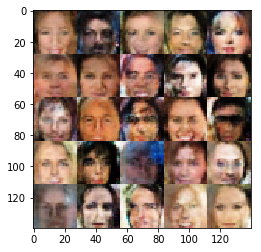

Epoch 1/1... Discriminator Loss: 1.1734... Generator Loss: 1.0074


In [19]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.